In [2]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf


In [3]:
#Importing the stock data using yahoo finance
df = yf.download('AMZN', start='2010-01-01', end='2020-12-01')
df.shape

[*********************100%***********************]  1 of 1 completed


(2747, 6)

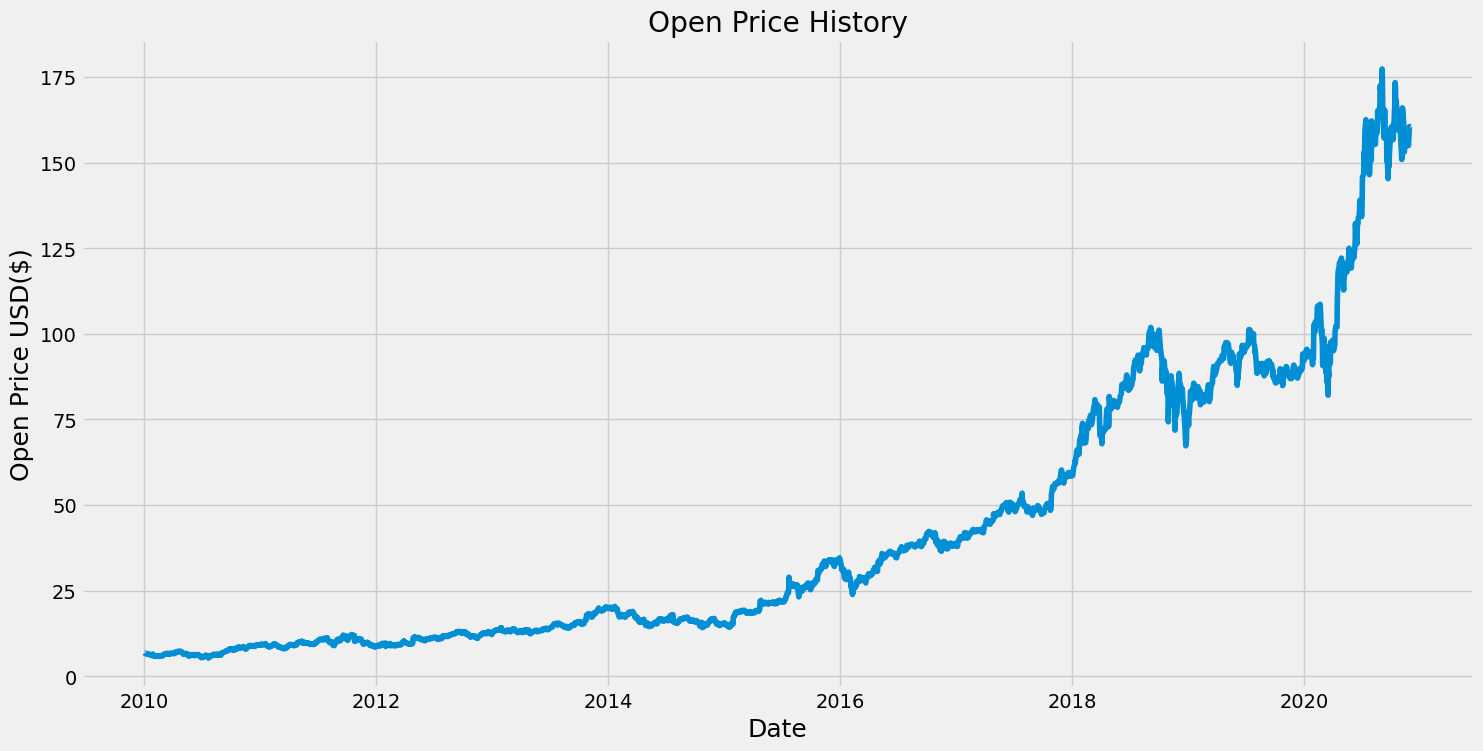

In [4]:
#Visualizing the opening price history

plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Open Price USD($)', fontsize = 18)
plt.show()

In [5]:
#create a new dataframe with only Open column
data = df.filter(['Open'])
#convert dataset into numpy array
dataset = data.values
#Get the number of rows to train the model on now using 80% of the given data set 
training_data_len = math.ceil(len(dataset)* 0.8)

training_data_len

2198

In [6]:
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00881121],
       [0.0079917 ],
       [0.00833171],
       ...,
       [0.88226627],
       [0.9024315 ],
       [0.90162357]])

In [7]:
#creating training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()


[array([0.00881121, 0.0079917 , 0.00833171, 0.00757904, 0.00715766,
       0.00775631, 0.0067014 , 0.00638464, 0.00674499, 0.00675662,
       0.00592257, 0.00616087, 0.00619865, 0.00571625, 0.00469912,
       0.00425158, 0.00438817, 0.00537623, 0.00692808, 0.00501297,
       0.00373721, 0.00325189, 0.00369362, 0.00289154, 0.00390867,
       0.00356575, 0.00350763, 0.00327805, 0.00379533, 0.00410628,
       0.00323736, 0.00287992, 0.00348147, 0.00332455, 0.00351053,
       0.003496  , 0.00355703, 0.00347276, 0.00371105, 0.00554479,
       0.00565812, 0.00582667, 0.00674209, 0.00650088, 0.00687577,
       0.00673628, 0.00712569, 0.00821547, 0.00748895, 0.00735527,
       0.00769528, 0.00729134, 0.00807307, 0.00705304, 0.00725356,
       0.00659969, 0.00674499, 0.00841889, 0.00855548, 0.008663  ])]
[0.008738560582640616]

[array([0.00881121, 0.0079917 , 0.00833171, 0.00757904, 0.00715766,
       0.00775631, 0.0067014 , 0.00638464, 0.00674499, 0.00675662,
       0.00592257, 0.00616087, 0.0

In [8]:
#convert the training dataset to numpy arrays to train the LSTM model

x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape

(2138, 60)

In [9]:
#Reshape the data( as LSTM requires the data to be in 3 dimension no of samples ,no of time-steps and no of features )

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_train.shape

(2138, 60, 1)

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17558613025456803783
xla_global_id: -1
]


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
# Define a custom wrapper class
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam', lstm_units=50, dropout_rate=0.2, epochs=10, batch_size=32):
        self.optimizer = optimizer
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size

    def build_model(self):
        model = Sequential()
        model.add(LSTM(units=self.lstm_units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(units=self.lstm_units))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).reshape(-1)

    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)  # Negate MSE because GridSearchCV minimizes the score

# Define hyperparameters grid
param_grid = {
    'lstm_units': [50],
    'batch_size': [ 32],
    'epochs': [ 55],
    'optimizer': ['adam'],
    'dropout_rate': [0.4]
}

# Create an instance of the custom wrapper
model = KerasRegressorWrapper()

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(x_train, y_train)

# Output the best parameters
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

23/23 [==============================] - 1s 14ms/step


KeyboardInterrupt: 